Epoch [1/15], Train Loss: 2.3523, Train Acc: 39.71%, Val Loss: 1.4497, Val Acc: 68.00%
Epoch [2/15], Train Loss: 1.0320, Train Acc: 79.71%, Val Loss: 0.8979, Val Acc: 81.78%
Epoch [3/15], Train Loss: 0.7429, Train Acc: 83.90%, Val Loss: 0.6510, Val Acc: 90.22%
Epoch [4/15], Train Loss: 0.5890, Train Acc: 87.05%, Val Loss: 0.5754, Val Acc: 87.56%
Epoch [5/15], Train Loss: 0.5254, Train Acc: 89.33%, Val Loss: 0.4713, Val Acc: 92.44%
Epoch [6/15], Train Loss: 0.4420, Train Acc: 90.10%, Val Loss: 0.4080, Val Acc: 94.22%
Epoch [7/15], Train Loss: 0.3919, Train Acc: 92.10%, Val Loss: 0.3509, Val Acc: 95.56%
Epoch [8/15], Train Loss: 0.3953, Train Acc: 91.71%, Val Loss: 0.4116, Val Acc: 93.33%
Epoch [9/15], Train Loss: 0.3763, Train Acc: 92.00%, Val Loss: 0.2918, Val Acc: 95.11%
Epoch [10/15], Train Loss: 0.3594, Train Acc: 92.67%, Val Loss: 0.2818, Val Acc: 96.89%
Epoch [11/15], Train Loss: 0.3416, Train Acc: 92.48%, Val Loss: 0.2644, Val Acc: 95.11%
Epoch [12/15], Train Loss: 0.3276, Train 

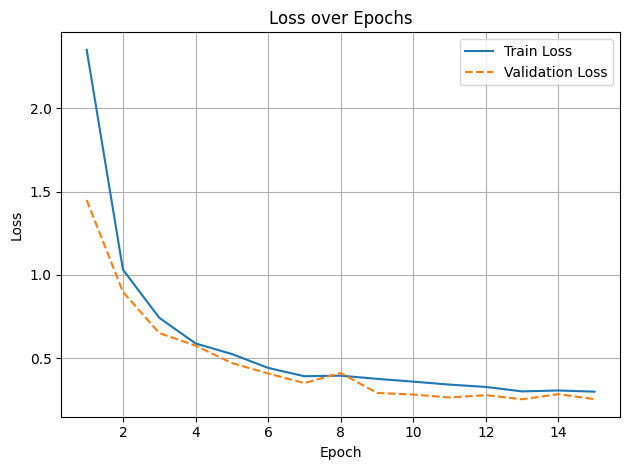

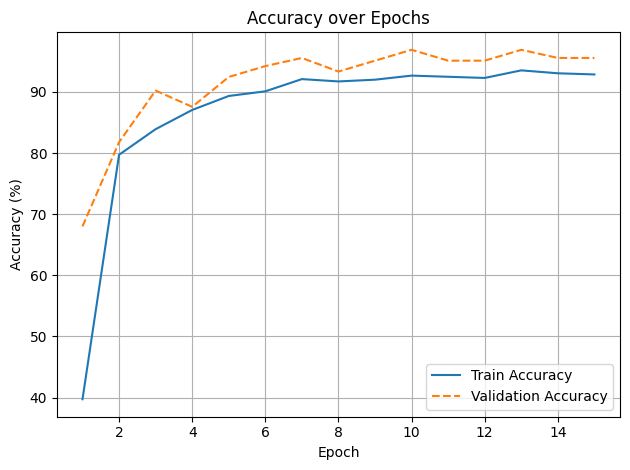

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "C:\\Users\\AJ\\PycharmProjects\\PythonProject\\USLD"

# Transform with data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load dataset
full_dataset = datasets.ImageFolder(dataset_path, transform=transform)
num_classes = len(full_dataset.classes)
class_names = full_dataset.classes

# Split dataset
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])

# Data loaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

# Model: VGG16
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify the final layer to match the number of classes
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001, weight_decay=0.01)

# Trackers
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')
patience = 5  # Early stopping patience
patience_counter = 0

# Train loop
epochs = 15  # Train for more epochs
for epoch in range(epochs):
    model.train()
    train_loss, correct_train, total_train = 0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

# Save model
torch.save(model.state_dict(), "vgg16_with_dropout_early_stopping.pth")

# -------------------------
# Training and Validation Curves
# -------------------------
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
